## Create Graph Plots of the Vector Images in Tempest

In [186]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def calvec(old_x,old_y,x,y,CALBRITE):
    vec=(x-old_x,y-old_y,CALBRITE)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_calvec_parms(parms):
    x,y = [x.replace('.','') for x in parms[0].split(',')]
    x = 0x00 if x == "NXE" else int(x,16)
    y = int(y,16)
    return (x,y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "CNTR":
            vecs+=[(0,0,"BLACK")]
        elif cmd == "CSTAT":
            color = parms[0]
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
        elif cmd == "VDOT":
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd in [".BRITE=VARBRT",".BRITE =VARBRT"]:
            CALBRITE=default_color
        elif cmd in [".BRITE=0",".BRITE =0"]:
            CALBRITE="BLACK"
        elif cmd == "CALVEC":
            x,y = parse_calvec_parms(parms)
            vec,old_x,old_y = calvec(old_x,old_y,x,y,CALBRITE)
            vecs+=[vec]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def plot_vertices(verts,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)

def plot_vertices_imgonly(verts,file_name,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    plt.axis('off')
    plt.savefig(f"vector_images/vec_image_{file_name}.png", bbox_inches='tight')

def tabulateVecsAndVerts(vectors,vertices):
    data =[["Vector X", "Vector Y", "Vertex X", "Vertex Y"]]
    for (vx,vy,_),(x,y,_) in zip(vectors,vertices):
        data +=[[str(vx),str(vy),str(x),str(y),]]
    table = tabulate.tabulate(data, tablefmt='html')
    return table

## Show How The Cursor is Built up From Vectors

In [267]:
def twos_complement(val, nbits):
    """Compute the 2's complement of int value val"""
    if val < 0:
        val = (1 << nbits) + val
    return val

a=2
hex(twos_complement(a,5))

'0x2'

[(0, 0, 'BLACK'), (4, -2, 'YELLOW'), (-3, -1, 'YELLOW'), (2, 1, 'YELLOW'), (-3, 1, 'YELLOW'), (-3, -1, 'YELLOW'), (2, -1, 'YELLOW'), (-3, 1, 'YELLOW'), (4, 2, 'YELLOW')]
Draw vector to (0,0)    & \icode{0x40C0}          & \icode{01000000 11000000} \\
Draw vector to (4,-2)    & \icode{0x5EC4}          & \icode{01011110 11000100} \\
Draw vector to (-3,-1)    & \icode{0x5FDD}          & \icode{01011111 11011101} \\
Draw vector to (2,1)    & \icode{0x41C2}          & \icode{01000001 11000010} \\
Draw vector to (-3,1)    & \icode{0x41DD}          & \icode{01000001 11011101} \\
Draw vector to (-3,-1)    & \icode{0x5FDD}          & \icode{01011111 11011101} \\
Draw vector to (2,-1)    & \icode{0x5FC2}          & \icode{01011111 11000010} \\
Draw vector to (-3,1)    & \icode{0x41DD}          & \icode{01000001 11011101} \\
Draw vector to (4,2)    & \icode{0x42C4}          & \icode{01000010 11000100} \\


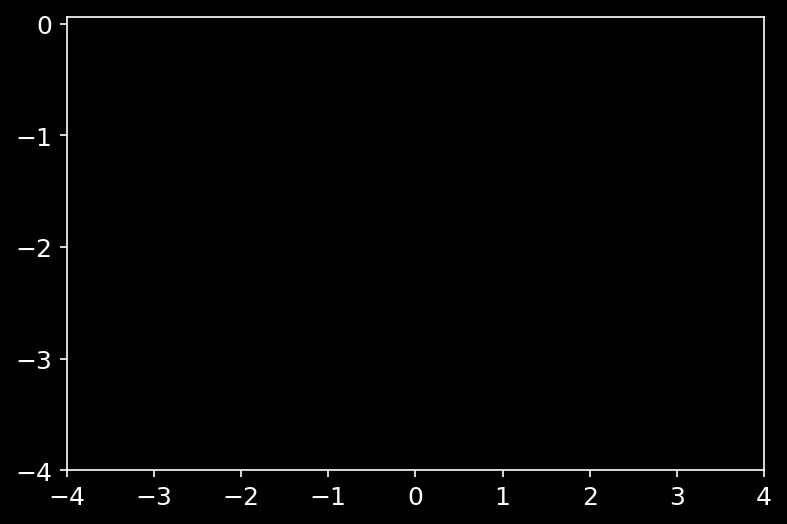

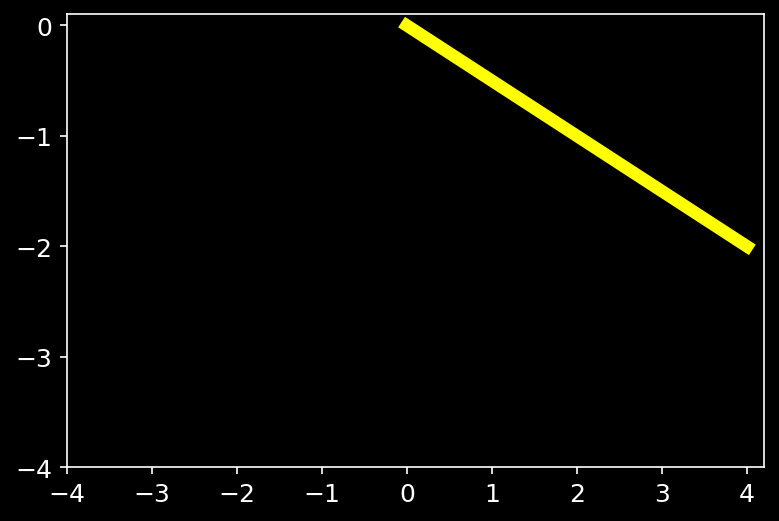

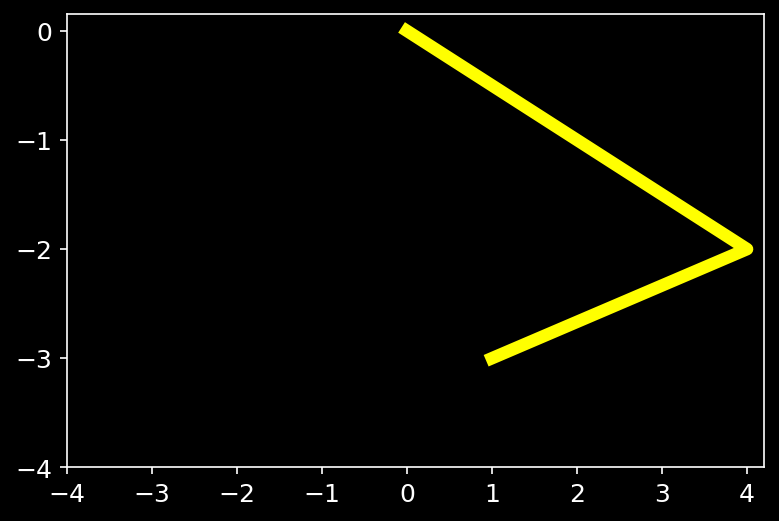

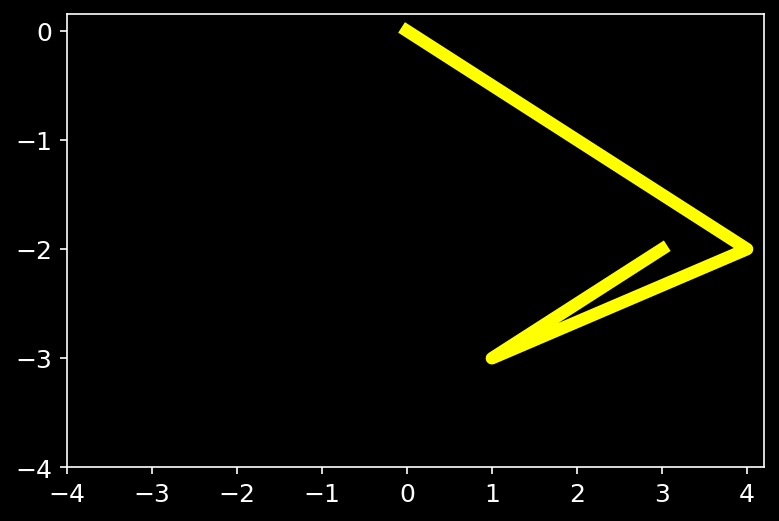

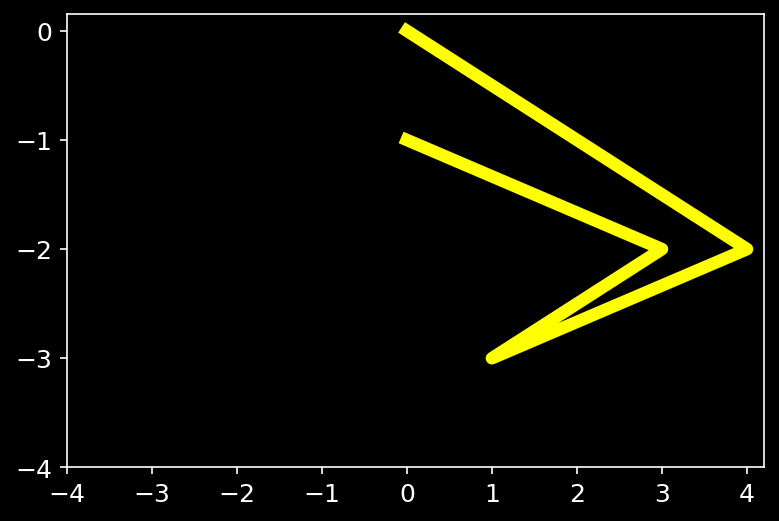

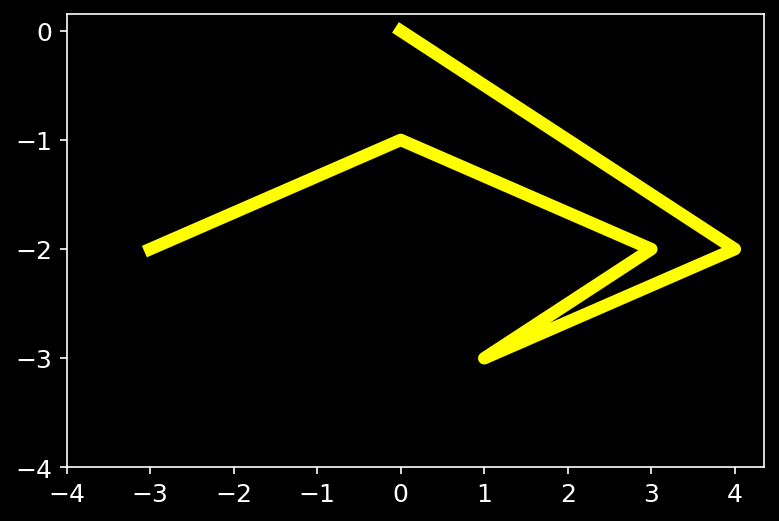

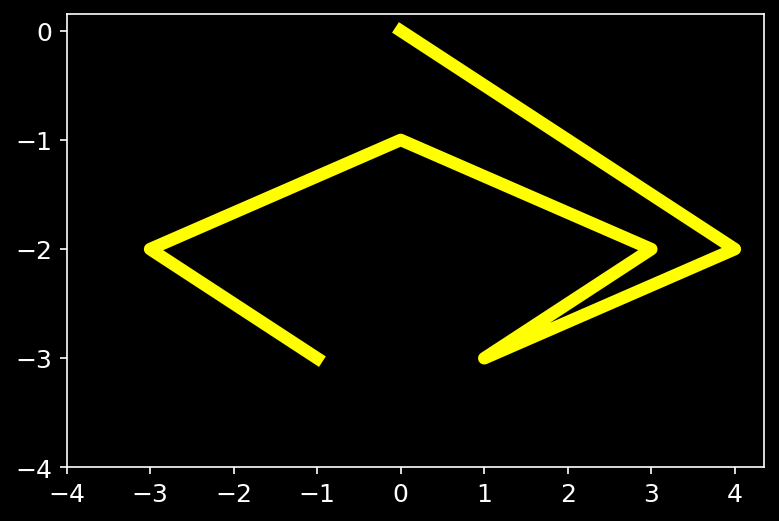

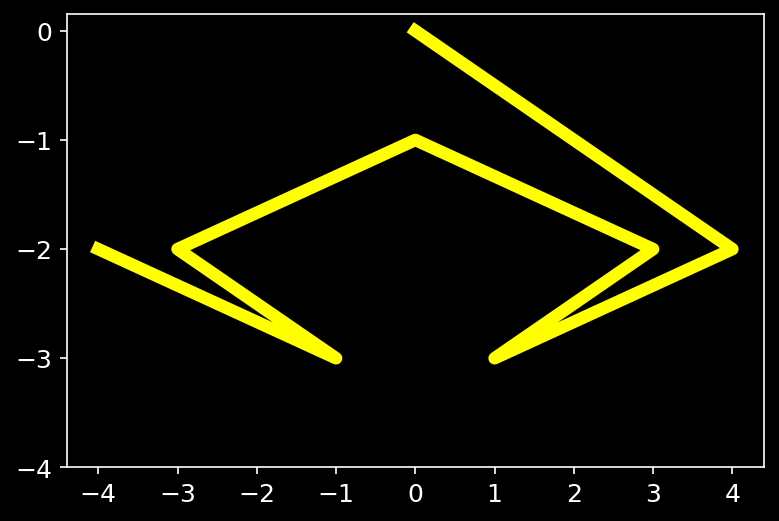

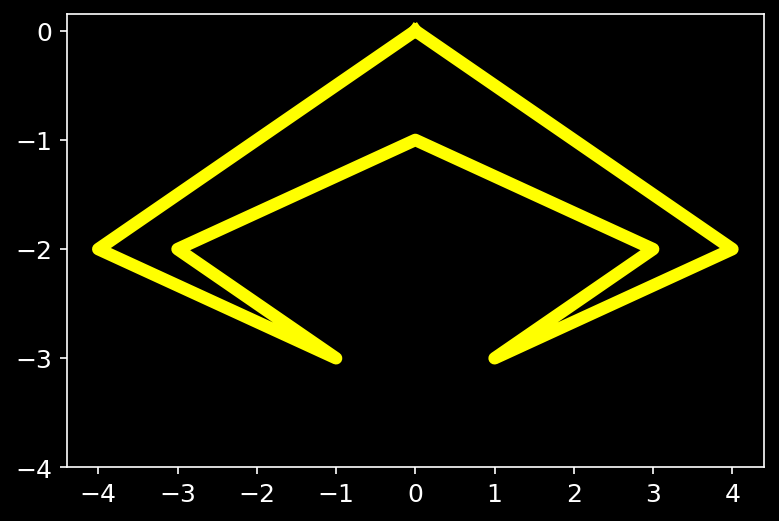

In [270]:
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

def twos_complement(val, nbits):
    """Compute the 2's complement of int value val"""
    if val < 0:
        val = (1 << nbits) + val
    return val

def create_opcodes(vectors):
    i = 6
    cvecs = []
    for x,y,_ in vectors:
        cvec = 0x4000
        cvec += i * 0x20
        
        cvec += twos_complement(x,5)
        cvec += (twos_complement(y,5) * 0x100) & 0x1F00
        
        hex_cvec = format(cvec,'04X')
        cvecs += [[hex_cvec,
                  format(int(hex_cvec[:2],16),'08b'), 
                  format(int(hex_cvec[2:],16),'08b'),
                  str(y),
                  str(x),
                  ]
                 ]
    return cvecs

def plot_gradual_vertices(verts,file_name_suffix,linewidth=6.0,points=""):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    ax.set_yticks(range(-4,1))
    ax.set_xticks(range(-4,5))
    ax.tick_params(axis='both', which='major', labelsize=linewidth*2)
    plt.savefig(f"lifes/build_cursor_{file_name_suffix}.png", bbox_inches='tight')

vector_data = """
LIFEY:
	CSTAT YELLOW
LIFE1:	
    ICVEC
	SCVEC 4,-2,CB
	SCVEC 1,-3,CB
	SCVEC 3,-2,CB
	SCVEC 0,-1,CB
	SCVEC -3,-2,CB
	SCVEC -1,-3,CB
	SCVEC -4,-2,CB
	SCVEC 0,0,CB
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
print(vectors)
vertices = vectors_to_coords(vectors)
for i in range(2,len(vertices)+1):
    for lw in [6]:
        plot_gradual_vertices(vertices[:i],f"{i}_{lw}",lw)

opcodes = create_opcodes(vectors)
for op,b1,b2,y,x in opcodes:
    print(f"Draw vector to ({x},{y})    & \icode{{0x{op}}}"
          f"          & \icode{{{b1} {b2}}} \\\\")


In [12]:
bin(int(0x5acc))

'0b101101011001100'

In [171]:
import tabulate
"""
	SCVEC 12,-12,CB
	SCVEC 3,-16,CB
	SCVEC 9,-12,CB
	SCVEC 0,-6,CB
	SCVEC -9,-12,CB
	SCVEC -3,-16,CB
	SCVEC -12,-12,CB
"""
vecs = [(x.split()[2],x.split()[-1].replace(".BRITE","6")) 
     for x in """
    10   326E  5ACC                             SCVEC 12,-12,6
    11   3270  5DD7                             SCVEC -7,-13,6
    12   3272  43C6                             SCVEC 12,6,1
    13   3274  43D7                             SCVEC 0,-1,1
    14   3276  5DD7                             SCVEC -3,-2,1
    15   3278  5DC6                             SCVEC -1,-3,1
    16   327A  43D7                             SCVEC -4,-2,1
    17   327C  46CC                             SCVEC 0,0,1
""".splitlines()[1:]]

data=[["Original","Bits","Parms","Calculated", "Bits"]]
for fvec, rvec in vecs:
    x,y,i = [int(x) for x in rvec.split(',')]
    cvec = 0x4000
    cvec += i * 0x20
    cvec += int(abs(x)) & 0x1F
    if x < 0:
        cvec |= 0x10
    cvec += (y*0x80) & 0x1F00
    if y < 0:
        cvec |= 0x1000
    data +=[[fvec,format(int(fvec,16),'016b'),rvec,hex(cvec), format(cvec,'016b')]]

table = tabulate.tabulate(data, tablefmt='html')
table


Original,Bits,Parms,Calculated,Bits
5ACC,0101101011001100,"12,-12,6",0x5acc,0101101011001100
5DD7,0101110111010111,"-7,-13,6",0x59d7,0101100111010111
43C6,0100001111000110,"12,6,1",0x432c,0100001100101100
43D7,0100001111010111,"0,-1,1",0x5f20,0101111100100000
5DD7,0101110111010111,"-3,-2,1",0x5f33,0101111100110011
5DC6,0101110111000110,"-1,-3,1",0x5e31,0101111000110001
43D7,0100001111010111,"-4,-2,1",0x5f34,0101111100110100
46CC,0100011011001100,"0,0,1",0x4020,0100000000100000


In [150]:
x = 0x02
hex(x * 0x80)

'0x100'